# Linear models in practice
In this lab session we will go over some important aspects of using linear models (and to some degree also neighborhood based models) in practice.
In particular, we will do some simple preprocessing and feature engineering. We will use the Boston housing dataset for this again.

## Data Scaling
Before we get started, we want to look at the data in more detail (you can look at ``boston.DESCR`` if you need a reminder about the data).

In [3]:
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline

from sklearn.datasets import load_boston
boston = load_boston()
X, y = boston.data, boston.target

### Task
Fill in the code below to create a scatter plot of each variable against the target. These univariate relationships can provide some insight into how to best model the problem.

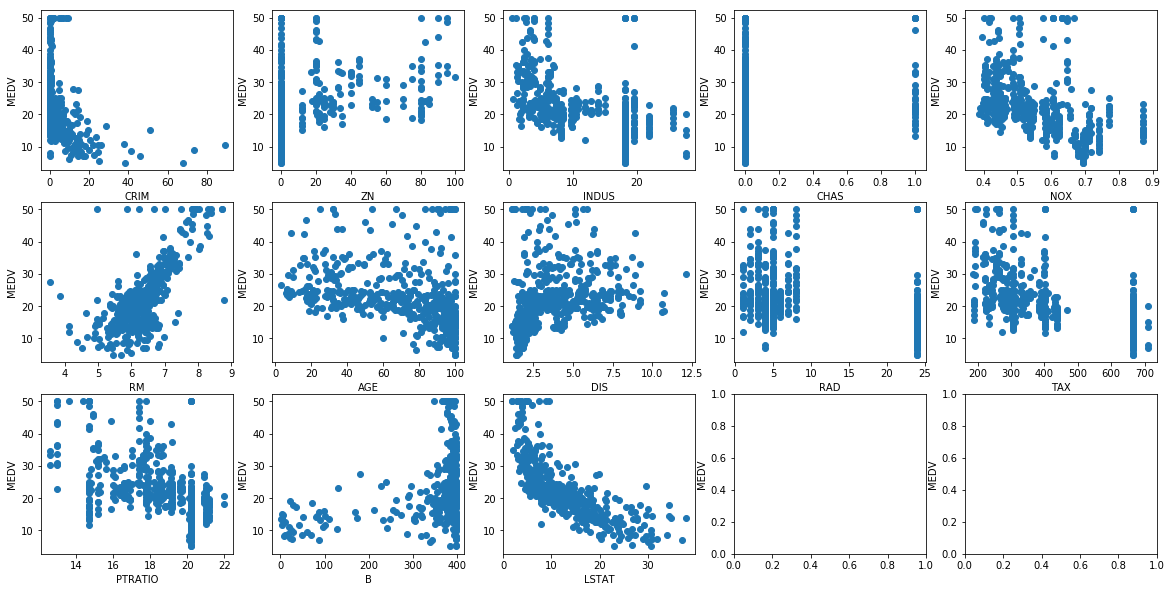

In [4]:
fig, axes = plt.subplots(3, 5, figsize=(20, 10))
for i, ax in enumerate(axes.ravel()):
    # plot the i-th feature in X against the target
    # label the x-axis
    # your code goes here...
#    print(i,ax)
    ax.set_ylabel("MEDV")
    try:
        ax.scatter(X[:,i],y)
        ax.set_xlabel(boston.feature_names[i])
    except:
        pass

plt.show()

The plot shows that for some features there is a clear dependence between the feature and the target. We can also see that the distributions of the different variables are quite different, as well as the ranges. We can see the difference between the ranges even more clearly if we do a box-plot of the features.

### Task
Create a boxplot of X. Make sure the axes are labeled properly.

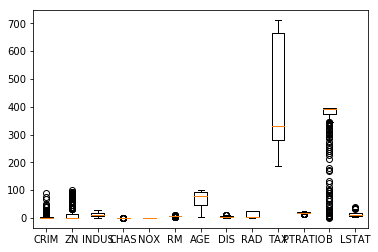

In [5]:
# Solution here ...
boston.feature_names
plt.boxplot(X,labels=boston.feature_names)
plt.show()


Having features of different orders of magnitude can be very detrimental for many models, for example regularized linear models and neighborhood based models - for linear regression without regularization, scaling of the input usually makes no difference, but can be benefitial to get a more stable solution.

There is a regression equivalent to ``KNeighborsClassifier``, called ``KNeighborsRegressor``. It simply predicts the mean of the ``n_samples`` closest training points.

### Task
Split the boston housing data into training and test set, apply the ``KNeighborsRegressor`` and compute the test set $R^2$.

In [6]:
# solution here
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor

X_train, X_test, y_train, y_test = train_test_split(
   X, y, random_state=0)

knr = KNeighborsRegressor()
knr.fit(X_train,y_train)
knr.score(X_test,y_test)

0.46163809246101117

The model is not very acurate and the problem should be clear from the box plot above: the TAX feature has a much larger magnitude than any other feature. That means this feature will completely dominate which data points are considered neighbors, and all other features will have little influence. A simple solution is to scale all the features to have the same scale. A common choice is to scale all features to zero mean and unit variance. We can do this with the ``StandardScaler`` from the ``sklearn.preprocessing`` module. It's important that we compute the mean and standard deviation of the data only on the training set, and then use these estimates for both the training and the test set.

### Task
Use the ``StandardScaler`` to rescale the Boston housing dataset. You can estimate the mean and variance by calling the ``fit`` method with the training data ``X_train`` (``y_train`` is not required). You can then scale the data using the ``transform`` method.
Store the scaled training data in to ``X_train_scaled`` and the scaled test data into ``X_test_scaled``. Compute mean and variance for both ``X_train_scaled`` and ``X_test_scaled``. Are they what you expect?

Now use the ``KNeighborsRegressor`` on the scaled data. The results should improve.

1.53948522513e-15 1.0
-0.00225746677586 1.02049923446


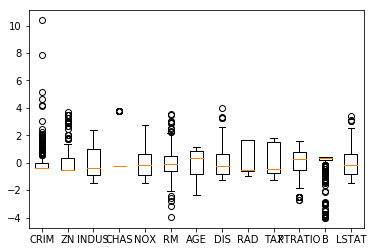

In [7]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()

ss.fit(X_train)
X_train_scaled = ss.transform(X_train)
X_test_scaled = ss.transform(X_test)

print(np.mean(X_train_scaled),np.var(X_train_scaled))
print(np.mean(X_test_scaled),np.var(X_test_scaled))

knr.fit(X_train_scaled,y_train)
knr.score(X_test_scaled,y_test)

plt.boxplot(X_train_scaled,labels=boston.feature_names)
plt.show()


## Regulariation
Coming back to linear models, we want to see what the effect of different amounts of regularization in a linear model is. Remember that the l2-penalized linear regression is called ``Ridge``.

### Task
Fit the Ridge model with the different values of ``alpha`` that are given. Record the ``R^2`` on the training and test set, and create a line plot comparing the two.

In [8]:
alphas = np.logspace(-3, 3, 7)
np.set_printoptions(suppress=True)
print(alphas)

[    0.001     0.01      0.1       1.       10.      100.     1000.   ]


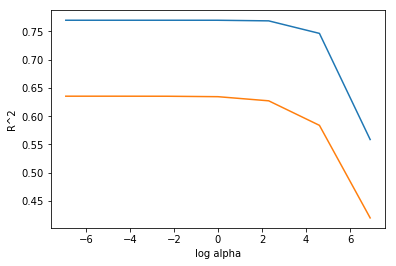

In [17]:
from sklearn.linear_model.ridge import Ridge
train_scores = []
test_scores = []


#ridge = ridge()
for alpha in alphas:
    # instantiate ridge with this particular alpha
    ridge = Ridge(alpha = alpha)
    # code here ...
    ridge.fit(X_train_scaled, y_train)
    ridge
    # compute training and test score, store them in train_scores and tests_scores
    train_scores.append(ridge.score(X_train_scaled,y_train))
    test_scores.append(ridge.score(X_test_scaled,y_test))

    # code here....
plt.plot(np.log(alphas),train_scores,label="training")
plt.plot(np.log(alphas),test_scores,label="testing")
plt.xlabel("log alpha")
plt.ylabel("R^2")
plt.show()

In [ ]:
# plot train_scores and test_scores here

In this case small values of alpha lead to the best training and test performances. This means little regularization is beneficial, and we could have also just used ``LinearRegression``.

## Polynomial Features
Looking at the univariate plots of features vs target that we did in the beginning of this lab, it's clear that not all the relationships between features and target are linear. The relationship for ``RM`` looks somewhat linear, but the relationship for ``LSTAT`` is clearly not.
There is several ways to deal with non-linear relationships. A particular simple one is adding polynomials of the original features as additional features, so for example adding $\text{LSTAT}^2$. We will also add interactions between features, which further increases the power of the model.
Both of these are implemented in the ``PolynomialFeatures`` transformation in ``sklearn.preprocessing``.

### Task
Transform the scaled data ``X_train_scaled`` and ``X_test_scaled`` with the ``PolynomialFeatures`` transformation.
How many features does transformed data have? Why?

Build a ridge model using the scaled data. Is it worth or better than the model we build before?

Now repeat the exercise from above and investigate the influence of different values of ``alpha`` on the model. How does the plot look different than before?

In [18]:
# Solution here
from sklearn.preprocessing import PolynomialFeatures

pf = PolynomialFeatures()

poly_train_data = pf.transform(X_train_scaled)
poly_test_data = pf.transform(X_test_scaled)

NotFittedError: This PolynomialFeatures instance is not fitted yet. Call 'fit' with appropriate arguments before using this method.

# Categorical Variables
Another common issue in working with linear models and related models is dealing with categorical variables. Linear models can't by themselves deal with categorical variables, but a simple way around that is using dummy variables, also known as one-hot encoding. Let's run through a small example with ``pandas``. Imagine you have a dataset with an integer column ``salary`` and a categorical column ``boro`` that takes the value of a boro of Manhattan:

In [ ]:
import pandas as pd
df = pd.DataFrame({'salary': [103, 89, 142, 54, 63, 219],
                   'boro': ['Manhatten', 'Queens', 'Manhatten', 'Brooklyn', 'Brooklyn', 'Bronx']})
df

To create a one-hot representation of the data, we can simply call the ``get_dummies`` function in pandas. It will represent each categorical feature as several new features, one for each category. All values of the features will be zero, except for the one feature representing the category assigned to this datapoint. So there will always be exactly one entry of "1" for each group of features.

In [ ]:
pd.get_dummies(df)

By default pandas encodes all variables that contains strings, objects, or categories (which is a pandas concept that we won't explain here - in this example we simply use strings). Sometimes you might encounter data in which someone has already "helpfully" encoded categories as integers:

In [ ]:
df = pd.DataFrame({'salary': [103, 89, 142, 54, 63, 219],
                   'boro': [0, 1, 0, 2, 2, 3]})
df

Calling ``get_dummies`` on this data will not do anything:

In [ ]:
pd.get_dummies(df)

To transform a categorical feature that's already encoded as an integer, you can pass it explicity:

In [ ]:
pd.get_dummies(df, columns=['boro'])

# Exercise
Apply dummy encoding and scaling to the "adult" dataset consisting of income data from the 1990s census.
The goal is to predict whether a person will make less or more than \$50k a year, so this is a binary classification problem.
Use logistic regression on the problem.

Bonus: identify important features and visualize them.

In [ ]:
data = pd.read_csv("https://github.com/amueller/ml-training-advanced/raw/master/notebooks/data/adult.csv", index_col=0)
# solution here ...